Mouse12-120810_stuff_simple_awakedata.mat
89
1
totnegLogL:  406392.02689725405
totnegLogL:  269757.254149128
totnegLogL:  170540.85766512516
totnegLogL:  164855.4935939568
totnegLogL:  164124.55437554538
totnegLogL:  163874.24680020072
totnegLogL:  163735.4301655817
totnegLogL:  163651.57444911244
totnegLogL:  163569.2894144161
totnegLogL:  163511.246112669


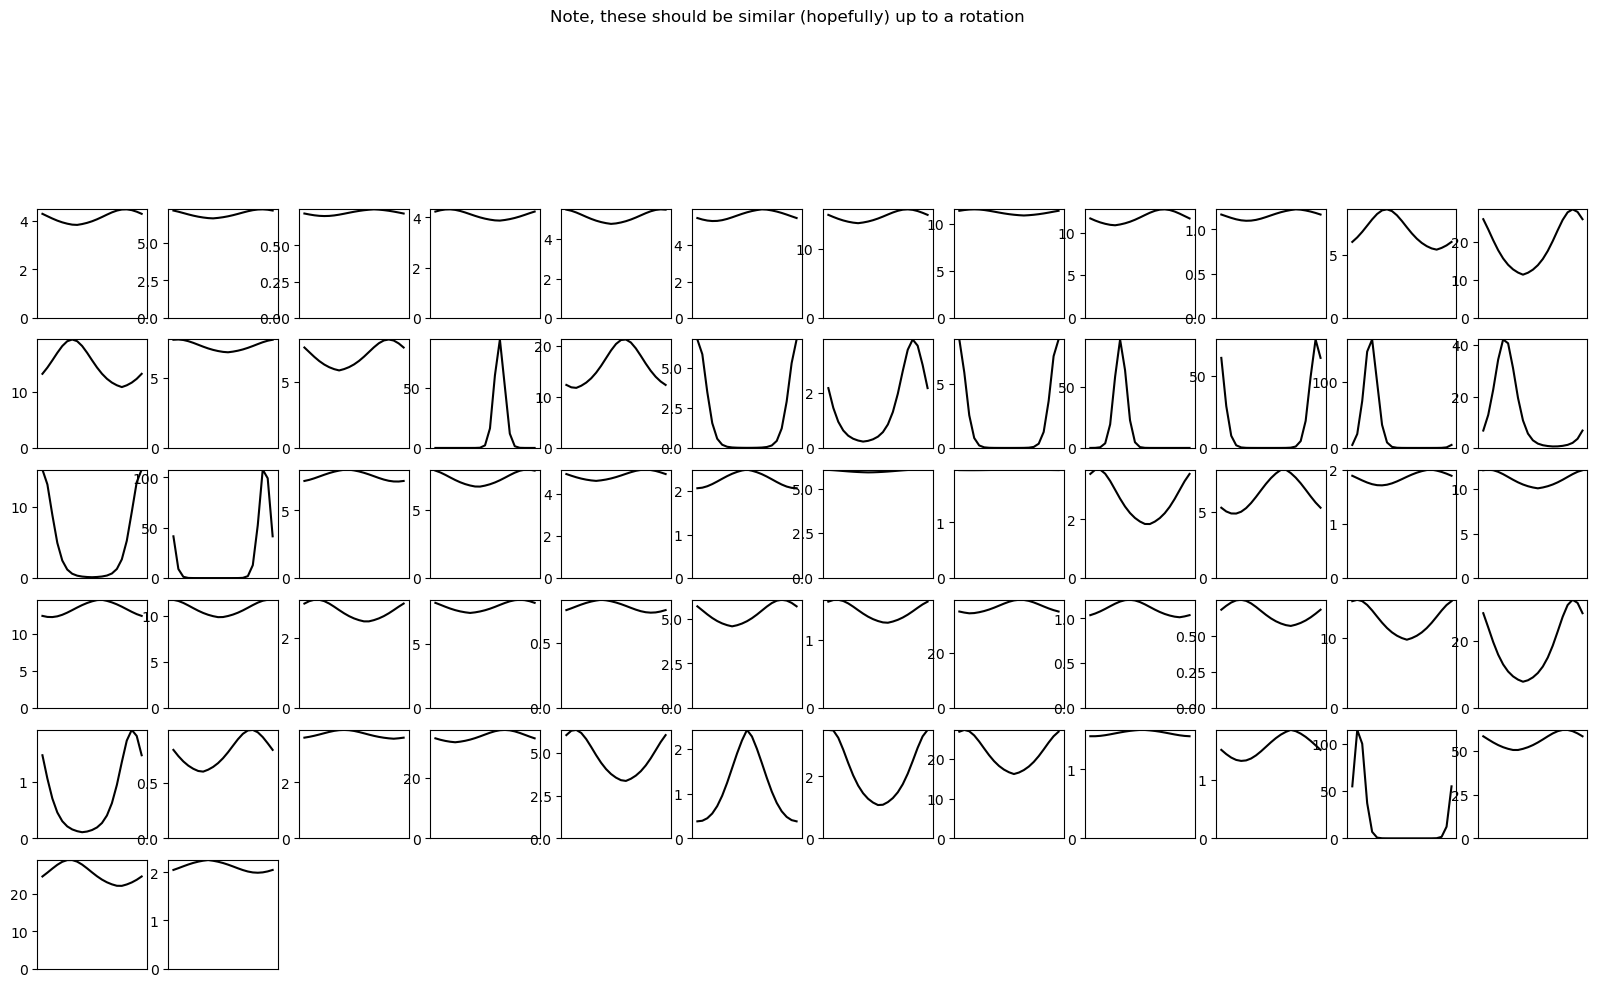

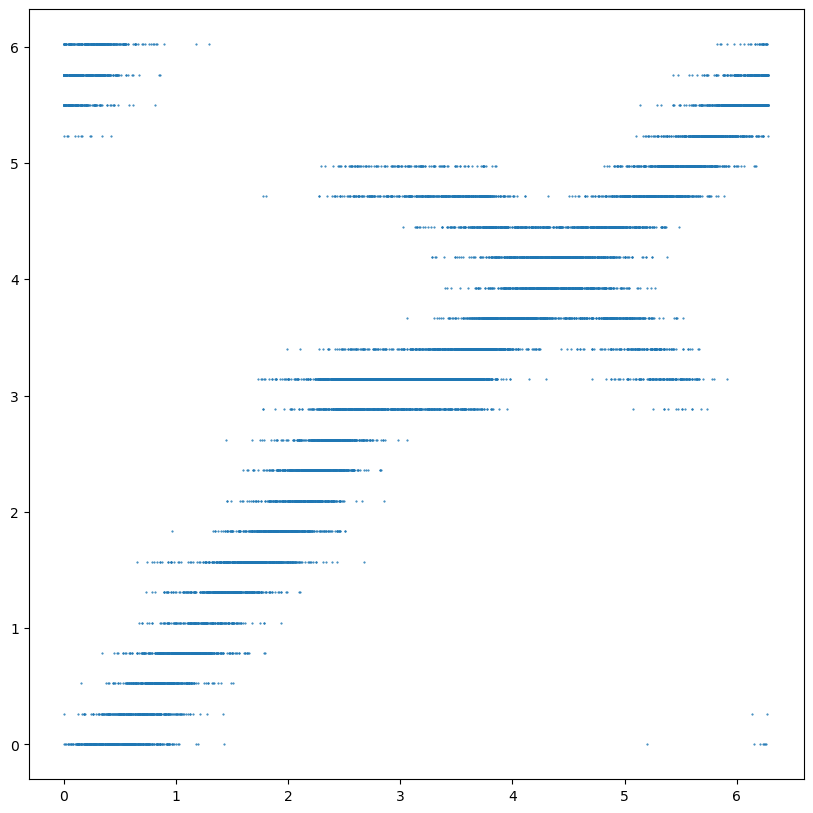

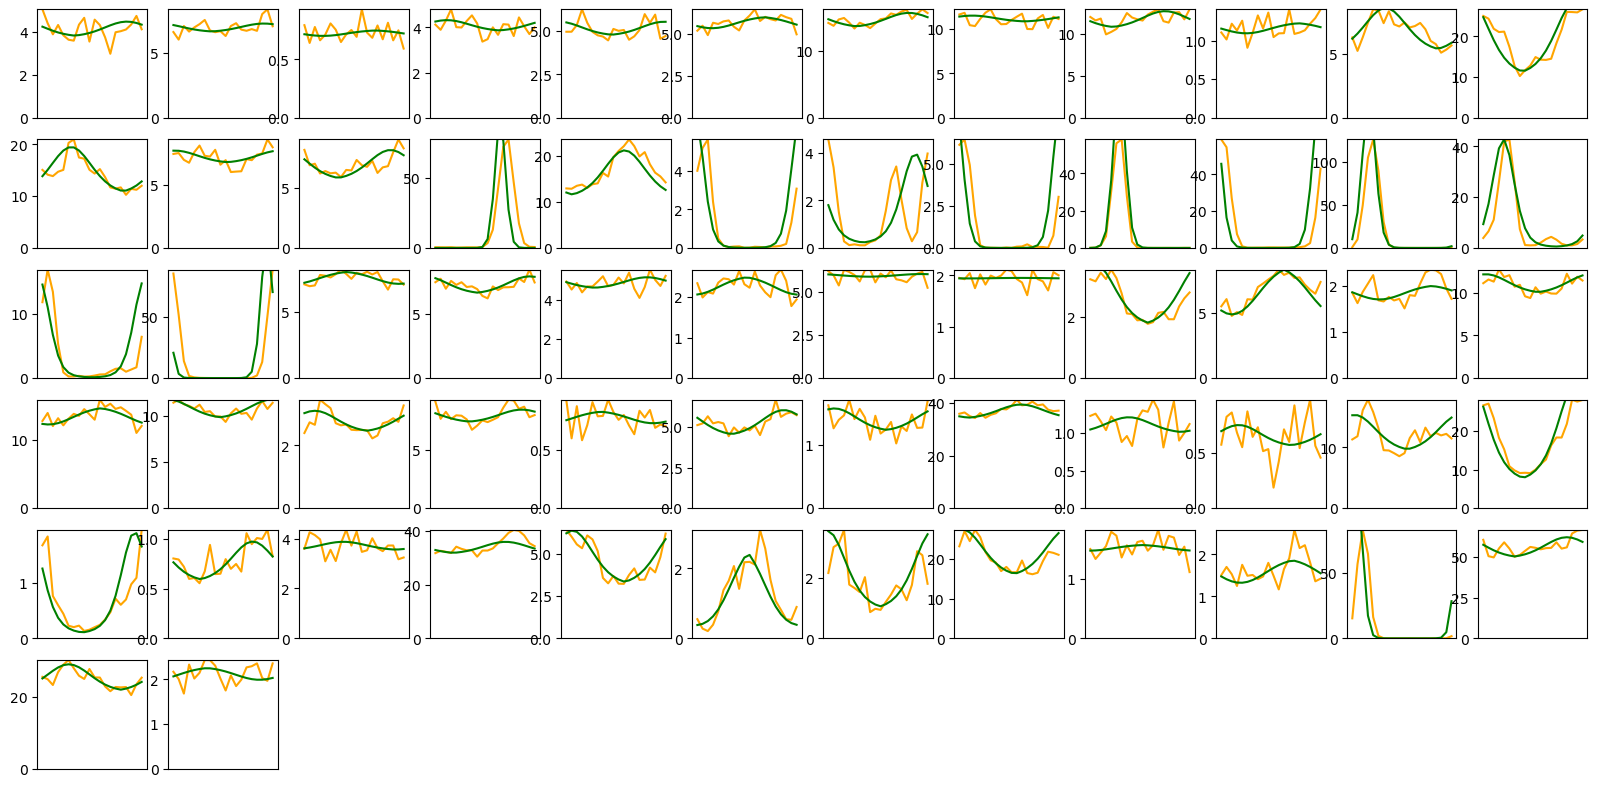

In [4]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.ndimage
import sys

name = 'Mouse12-120810_stuff_simple_awakedata.mat'
#name = sys.argv[1]
print(name)

thresholdforneuronstokeep = 1000 # number of spikes to be considered useful

mat = scipy.io.loadmat(name)
cellspikes = np.array(mat['cellspikes'])
cellnames = np.array(mat['cellnames'])
N = len(cellnames)
M= len(cellspikes)
print(N)
print(M)

## get tracking data and downsample it (every 5th) so that
## i have a bigger times scale for the data and neurons
## can be assumed to be poisson(ish)
trackingtimes = np.ravel(np.array(mat['trackingtimes']))
headangle = np.ravel(np.array(mat['headangle']))
sss = np.mod(np.arange(len(trackingtimes)),5)==0 
trackingtimes = trackingtimes[sss]
headangle = headangle[sss]

## make matrix of spikes
startt = np.min(trackingtimes)
binsize = np.mean(trackingtimes[1:]-trackingtimes[:(-1)])
T = len(trackingtimes)
S = np.zeros((N, T))
sgood = np.zeros(N)<1
for i in range(N):
  spikes = np.ravel((cellspikes[0])[i])
  for j in range(len(spikes)):
    tt = int(np.floor(  (spikes[j] - startt)/float(binsize)  ))
    if(tt>T-1 or tt<0): # check if outside bounds of the awake time
      continue
    S[i,tt] += 1 # add a spike to the thing

  ## check if actvitity is ok
  if(sum(S[i,:])<thresholdforneuronstokeep):
      sgood[i] = False
      continue

S = S[sgood,:]
cellnames = cellnames[sgood]
N = len(cellnames)


#FIXED WIDTH
sigma = 7.*np.pi/16.
def getH(a, D): ## H is the "lambda" for the Poisson random variable
  tc_prefdir = a[0] % (2.*np.pi)
  tc_beta = a[1]
  tc_h = a[2]
  dtheta = np.abs(D - tc_prefdir)
  dtheta = np.minimum(dtheta, 2.*np.pi - dtheta)
  return( tc_h + tc_beta * np.exp(-dtheta**2 / (2 * sigma**2)) )

def logLtc(a, Sj, D): ## negative log likelihood of the Poisson
  H = getH(a, D)
  return(-np.sum( Sj * H - np.exp(H) ))

from scipy.optimize import minimize
def getparams(DD):
    def getscore(val, j):
      ## note i use numerical solver because derivatives in "preferred direction"
      ## would be horrible. you could do the exact derivatives for the others but this is fine
      def doone(a):
        return(logLtc(a, S[j,:], DD))
      result = minimize(doone, [val, 3, -2] , method='L-BFGS-B')
      return(result)

    totnegLogL = 0
    params = np.zeros((N, 3))
    for i in range(N):
      res = getscore(0, i)
      params[i,:] = res.x
      totnegLogL += res.fun
    print('totnegLogL: ', totnegLogL)
    return(params, totnegLogL)



def getpreddir(params):
    def getlogl(Dtry):
      logl = np.zeros(len(Dtry))
      for i in range(N):
        H = getH(params[i,:], Dtry)
        logl += -( S[i,:] * H - np.exp(H) )
      return(logl)

    ## optimize for direction using stupid grid search method
    Dc = np.zeros(T)
    Lc = getlogl(Dc)
    dspace = np.pi/12.
    for val in np.arange(4.*np.pi, 6.*np.pi, dspace):
      Dt = np.ones(T)*val
      Lt = getlogl(Dt%(2.*np.pi))
      whiches = Lt<Lc
      if(np.sum(whiches)>0):
        Dc[whiches] = Dt[whiches]
        Lc[whiches] = Lt[whiches]

    if(False): 
        ### the following has some little bug in it.
        ### it is supposed to further optimize, starting from the best solution in the grid search
        ### and check in shrinking bounds (so before I assume the problem has many potential optima
        ### and here I assume it has one optima and i can find it using shrinking bounds). Note,
        ### this is a very inefficient optimization scheme but my goal is to keep the code simple
        ### so theere is no mystery
        for i in range(10):
          jump = dspace/(2.**(i+1))
          Dcold = Dc + 0.
          for val in np.arange(-jump/2., jump/2.+0.00001, jump):
            Dt = Dcold + val*np.ones(len(Dcold))
            Lt = getlogl(Dt)
            whiches = Lt<Lc
            if(np.sum(whiches)>0):
              Dc[whiches] = Dt[whiches]
              Lc[whiches] = Lt[whiches]

    return(Dc%(2.*np.pi))




DD = np.random.rand(T)*(2.*np.pi)
#DD = headangle + 0.


if(np.sum(np.isnan(DD))>0):
  DD[np.isnan(DD)] = 0.
for i in range(10): 
  params, totlogL = getparams(DD)



  DD = getpreddir(params)

  fig = plt.figure(2, figsize=(20,20))
  plt.clf()
  angles = np.arange(0, 2.*np.pi+0.0001, np.pi/10)


  for j in range(N):
    fr = plt.subplot(12,12,j+1)
    tuningcurve = np.exp(getH(params[j,:], angles)) * 1000./binsize
    plt.plot(angles, tuningcurve, '-', color='black')
    plt.ylim(0, np.max(tuningcurve))
    fr.axes.get_xaxis().set_visible(False)
  fig.suptitle('log(L) = %f'%(-totlogL))
  plt.savefig('%s_lvm_2vect_%03d.png'%(name[:(-4)], i))

  plt.figure(10, figsize=(10,10))
  plt.clf()
  plt.plot(headangle, DD, '.', ms=1)
  plt.savefig('%s_lvm_2dirc_%03d.png'%(name[:(-4)], i))

  
# Make tuning curves from the data
angles = np.arange(0, 2.*np.pi+0.0001, np.pi/10)
anglevertices = (0.5*(angles[0:(-1)]+angles[1:]))
occupancies = np.zeros(len(angles)-1)
tuningcurveO = np.zeros((len(cellnames), len(angles)-1))
for i in range(len(angles)-1):
  inds = (headangle>=angles[i]) * (headangle<angles[i+1])
  occupancies[i] = np.sum(inds)
  if(occupancies[i]>0):
    for j in range(len(cellnames)):
      tuningcurveO[j,i] = np.sum( S[j,inds] ) / float( occupancies[i] )
      tuningcurveO[j,i] = tuningcurveO[j,i] * 1000./binsize
  else:
    tuningcurveO[:,i] = np.NAN


tuningcurveF = np.zeros((N, len(anglevertices)))
for i in range(N):
  tuningcurveF[i] = np.exp(getH(params[i,:], anglevertices)) * 1000./binsize

plt.figure(1, figsize=(20,20))
for i in range(len(cellnames)):
  fr = plt.subplot(12,12,i+1)
  plt.plot(anglevertices, tuningcurveO[i,:], '-', color='orange')
  plt.plot(anglevertices, tuningcurveF[i,:], '-', color='green')
  plt.ylim(0, np.max([np.max(tuningcurveO[i,:]), np.max(tuningcurveO[i,:])]))
  fr.axes.get_xaxis().set_visible(False)
fig.suptitle('Note, these should be similar (hopefully) up to a rotation')
plt.savefig('%s_lvm_allopt_sigma_vect_%05d.png'%(name[:(-4)], np.floor(sigma*1000)))


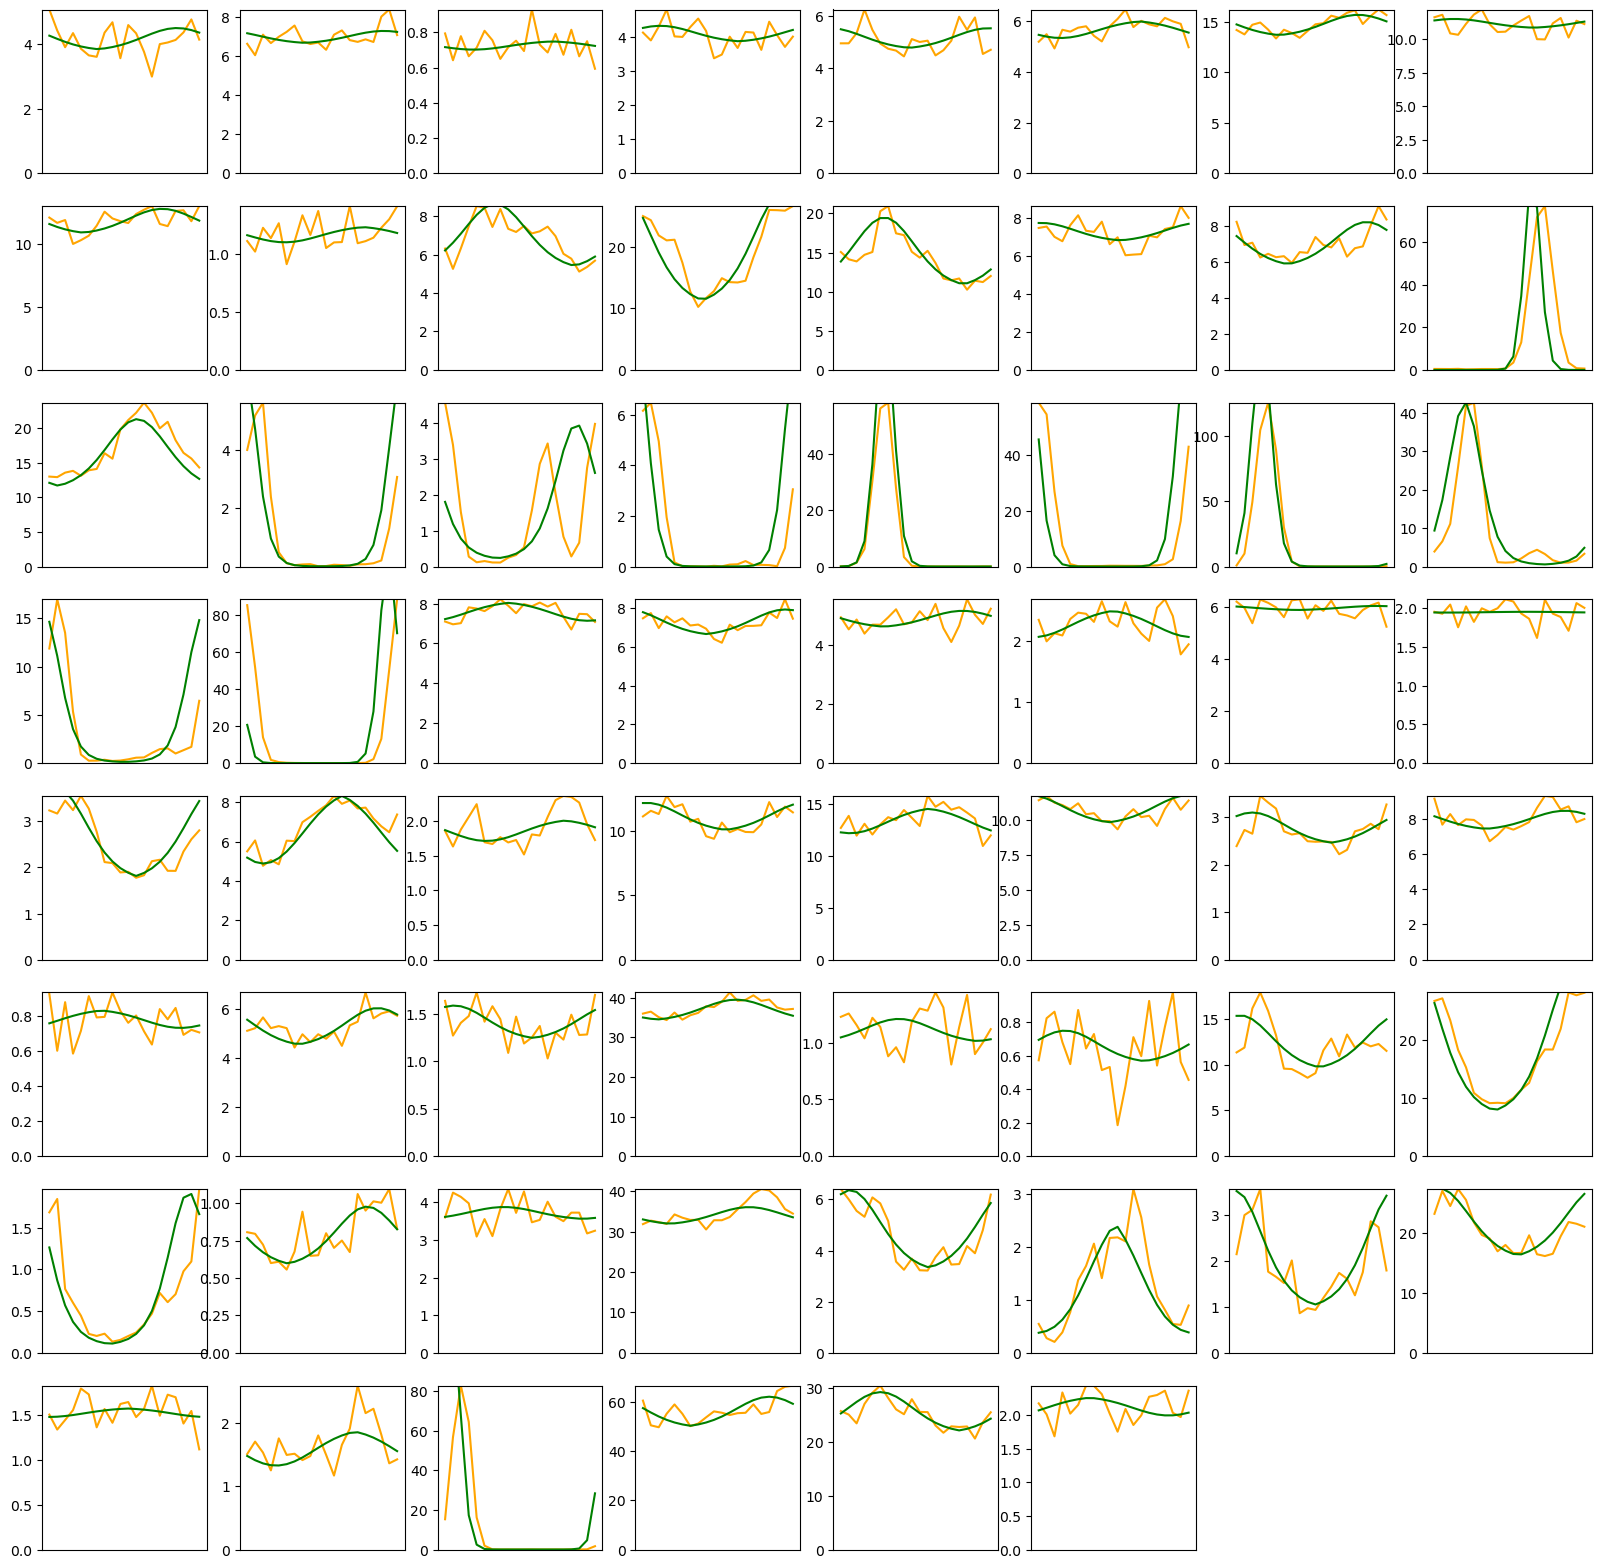

In [5]:
plt.figure(1, figsize=(20,20))
for i in range(len(cellnames)):
  fr = plt.subplot(8,8,i+1)
  plt.plot(anglevertices, tuningcurveO[i,:], '-', color='orange')
  plt.plot(anglevertices, tuningcurveF[i,:], '-', color='green')
  plt.ylim(0, np.max([np.max(tuningcurveO[i,:]), np.max(tuningcurveO[i,:])]))
  fr.axes.get_xaxis().set_visible(False)
fig.suptitle('Note, these should be similar (hopefully) up to a rotation')
plt.savefig('%s_lvm_allopt_sigma_vect_%05d.png'%(name[:(-4)], np.floor(sigma*1000)))